In [1]:
# PyMC3 for Bayesian Inference
import pymc3 as pm

# Pandas and numpy for data manipulation
import pandas as pd
import numpy as np

# Scikit-learn utilities
from sklearn.model_selection import train_test_split

# Matplotlib and seaborn for visualizations
import matplotlib.pyplot as plt
%matplotlib inline

WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
df = pd.read_csv('data/HI_Small_Trans_Standardised.csv')
df.head()

,From Account,To Account,From Bank,To Bank,Receiving Currency,Payment Currency,Payment Format,Timestamp,Amount Paid,Amount Received,Is Laundering
0,6263,6386,8,8,12,12,5,2022-09-01 00:20:00,3697.34,3697.34,0
1,342898,172656,109,0,12,12,3,2022-09-01 00:20:00,0.01,0.01,0
2,343200,328327,110,106,12,12,5,2022-09-01 00:00:00,14675.57,14675.57,0
3,71212,72895,10,10,12,12,5,2022-09-01 00:02:00,2806.97,2806.97,0
4,6270,6394,8,8,12,12,5,2022-09-01 00:06:00,36682.97,36682.97,0


In [3]:
# feature pre-processing
# Benford's law: Add first leading digit from both "Amount Paid" & "Amount Received" columns

def get_first_digit(figure:float) -> int:
    exception_set = ('0','.','e','-')
    for char in str(figure):
        if char not in exception_set:
            return int(char)

# df['LD Amount Paid'] = df['Amount Paid'].astype(str).str[:1].astype(int)
df['LD Amount Paid'] = df.apply(lambda x: get_first_digit(x['Amount Paid']), axis=1)
# df['LD Amount Received'] = df['Amount Received'].astype(str).str[:1].astype(int)
df['LD Amount Received'] = df.apply(lambda x: get_first_digit(x['Amount Received']), axis=1)

df.head()

,From Account,To Account,From Bank,To Bank,Receiving Currency,Payment Currency,Payment Format,Timestamp,Amount Paid,Amount Received,Is Laundering,LD Amount Paid,LD Amount Received
0,6263,6386,8,8,12,12,5,2022-09-01 00:20:00,3697.34,3697.34,0,3,3
1,342898,172656,109,0,12,12,3,2022-09-01 00:20:00,0.01,0.01,0,1,1
2,343200,328327,110,106,12,12,5,2022-09-01 00:00:00,14675.57,14675.57,0,1,1
3,71212,72895,10,10,12,12,5,2022-09-01 00:02:00,2806.97,2806.97,0,2,2
4,6270,6394,8,8,12,12,5,2022-09-01 00:06:00,36682.97,36682.97,0,3,3


<Axes: ylabel='Frequency'>

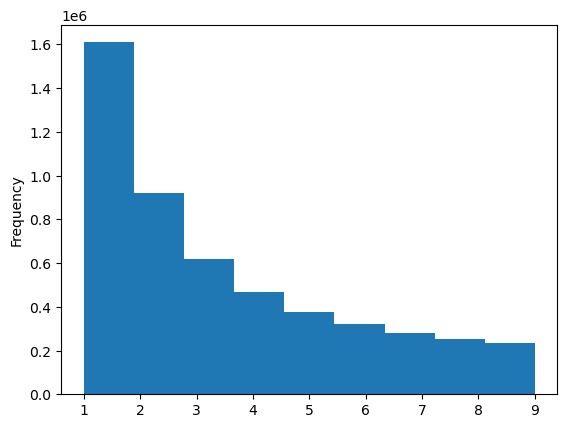

In [6]:
df['LD Amount Paid'].plot.hist(bins=9)

# from matplotlib.ticker import PercentFormatter

# #create histogram, using percentages instead of counts
# plt.hist(df['LD Amount Paid'], bins=9, edgecolor='black')

# #apply percentage format to y-axis
# plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
# plt.show()